<a href="https://colab.research.google.com/github/Iceoid/datascience-ml-class/blob/main/TP3_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Basic Libraries

`%pylab inline` imports the basic libraries (numpy, matplotlib)


In [ ]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


---

# Scikit-learn

Scikit-learn (formerly scikits.learn and also known as sklearn) is a free software machine learning library for the Python programming language. It features various classification, regression and clustering algorithms including support vector machines, random forests, gradient boosting, k-means and DBSCAN, and is designed to interoperate with the Python numerical and scientific libraries NumPy and SciPy.

More information can be found on their website https://scikit-learn.org/stable/. This includes tutorials, examples, documentation and overview of algorithms.

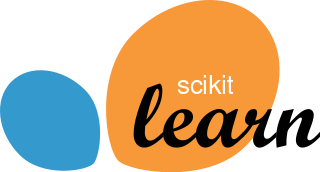


The library is very comprehensive, almost everything you need for machine learning is available (except complex neural networks).
Sklearn also includes many common ML datasets. They are pre-processed and ready to use.

We will import the Iris flower dataset. 

In [ ]:
from sklearn import datasets
from sklearn import preprocessing
from sklearn.utils import shuffle

# Load the dataset
iris = datasets.load_iris()
data = iris.data
target = iris.target

# Select only versicolor and virginica flowers
data_x = data[50:]
data_y = target[50:]

# Binarize the labels (to 0 or 1)
labelencoder = preprocessing.LabelEncoder()
labelencoder.fit(data_y)
data_y = labelencoder.transform(data_y)

# Shuffle the dataset
data_x, data_y = shuffle(data_x, data_y, random_state=42)

print("Inputs shape:", data_x.shape) # Print shape of dataset
print("Outputs shape:", data_y.shape) # Print shape of dataset

Inputs shape: (100, 4)
Outputs shape: (100,)


In [ ]:
print("First 10 entries of the dataset:")
print(data_x[0:10])
print(data_y[0:10])

First 10 entries of the dataset:
[[6.3 2.8 5.1 1.5]
 [6.3 2.9 5.6 1.8]
 [6.9 3.2 5.7 2.3]
 [5.7 3.  4.2 1.2]
 [5.6 2.7 4.2 1.3]
 [5.5 2.5 4.  1.3]
 [6.3 2.5 4.9 1.5]
 [7.4 2.8 6.1 1.9]
 [5.  2.  3.5 1. ]
 [7.  3.2 4.7 1.4]]
[1 1 1 0 0 0 0 1 0 0]


---

## k-NN and KDE Definition

In [ ]:
# Distance function, returns the distance between x and y
def distance(x, y):
    return np.sum((x - y) ** 2, axis=-1)

# Takes in one unknown input, training dataset, training labels and k
# Outputs the predicted class
def knn(x, dataset_x, dataset_y, k):
    argmin_indices = argsort(distance(x, dataset_x))
    k_nearest_neighbours = dataset_y[argmin_indices[0:k]]

    class_0 = np.sum(k_nearest_neighbours == 0)
    class_1 = np.sum(k_nearest_neighbours == 1)

    if class_0 > class_1:
        return 0
    elif class_1 > class_0:
        return 1
    else:
        return -1

# Takes in unknown inputs, training dataset, training labels and k (optional, default = 3)
# Outputs the array of predictions
def knn_batch(unknowns_x, dataset_x, dataset_y, k=3):
    return np.array([knn(x, dataset_x, dataset_y, k) for x in unknowns_x])

# Gaussian kernel function with sigma s
def kernel(x, s):
    return np.exp(-(x**2)/(s**2)) # Generalized "gaussian-like" kernel equation: e^-|x|^p / s^p

# Takes in one unknown input, training dataset, training labels and sigma
# Outputs the predicted class
def kde(x, dataset_x, dataset_y, s):
    weights = kernel(distance(x, dataset_x), s)
    class_0 = np.sum(weights[dataset_y == 0])
    class_1 = np.sum(weights[dataset_y == 1])

    return 0 if class_0 > class_1 else 1

# Takes in unknown inputs, training dataset, training labels and sigma (optional, default = 4)
# Outputs the array of predictions
def kde_batch(unknowns_x, dataset_x, dataset_y, s=4):
    return np.array([kde(x, dataset_x, dataset_y, s) for x in unknowns_x])

---

## Model Validation

Scikit-learn has implementations for dataset splitting, but first try to implement them in numpy.

In [ ]:
# Accuracy of prediction for binary classification labels
def accuracy(predicted_y, real_y):
    return 1 - np.mean(np.clip(np.abs(predicted_y - real_y), 0, 1))

# Shuffles and splits the dataset (dataset_x, dataset_y) into (train_x, train_y, test_x, test_y). test_split (a number between 0 and 1) is the amount of data to be kept for testing.
def split_dataset(dataset_x, dataset_y, test_split):
    dataset_x, dataset_y = shuffle(dataset_x, dataset_y) #Shuffle the dataset
    idx = int(len(dataset_x) * (1 - test_split))
    return dataset_x[:idx], dataset_y[:idx], dataset_x[idx:], dataset_y[idx:]

# Tests the knn algorithm, returns the accuracy on test_x
def test_knn(train_x, train_y, test_x, test_y, k):
    pred_y = knn_batch(test_x, train_x, train_y, k)
    return accuracy(pred_y, test_y)

# Tests the kde algorithm, returns the accuracy on test_x
def test_kde(train_x, train_y, test_x, test_y, s):
    pred_y = kde_batch(test_x, train_x, train_y, s)
    return accuracy(pred_y, test_y)

### Model Validation - Exercises
1.   Split the dataset into 70% train and 30% test.
2.   Using $k=3$ and $\sigma=0.1$ for k-NN and KDE respectively, what is the accuracy obtained on the test set?
  * 94% for k-NN and 95% for KDE.
3.   Is it valid to manually modify $k$ and $\sigma$ until the accuracy increases? Discuss.
  * No, it is not valid to modify hyperparameters using the test set. For correct expected risk estimation, we must use a validation split.



In [ ]:
train_x, train_y, test_x, test_y = split_dataset(data_x, data_y, 0.3)

In [ ]:
print("KNN Accuracy:", test_knn(test_x, test_y, train_x, train_y, 3))
print("KDE Accuracy:", test_kde(test_x, test_y, train_x, train_y, 0.1))

KNN Accuracy: 0.9428571428571428
KDE Accuracy: 0.9571428571428572


### Hyperparameter Selection - Exercises

As seen in class, we must split the dataset into three (train, validate, test) in order to select hyperparameters.

4.   Using `split_dataset` implemented in **1)**, split the dataset into 60% train, 20% validate, 20% test. (Hint: First split the dataset into 60/40, then split the latter portion in two again.)
5.   Find the best $k$ and $\sigma$ using the validation set. Use linear search for k-NN (eg. $k=(13, 11, 9, ...)$) and a decay regime for $\sigma$ (eg. start with $\sigma_0=10$ and multiply by $0.9$ for each iteration $(\sigma_{i+1}=0.9\sigma_i)$, stop when $\sigma<{0.001}$).
6.   Merge the validation set into the training set. After training a new model with the best hyperparameters on this larger training set, verify and confim good generalization by testing on the test set. What is the final accuracy on the best hyperparameters?
  * 95% for k-NN with $k=7$ and 95% for KDE with $\sigma=0.47$.
7.   Shuffle the dataset randomly and try **4), 5)** and **6)** again a few times. What do you notice? Are the best hyperparameters different each time? Discuss.
  * There are large variations across different runs. This might suggest that the testing dataset is too small and we are not getting a good estimate of the expected risk.

In [ ]:
def big_test(iters=10):
    for i in range(iters):

        # Split the dataset randomly
        train_x, train_y, test_x, test_y = split_dataset(data_x, data_y, 0.4)
        valid_x, valid_y, test_x, test_y = split_dataset(test_x, test_y, 0.5)

        # Find the best k
        best_k_score = 0
        best_k = 13

        for k in range(13, 0, -2):
            score = test_knn(train_x, train_y, valid_x, valid_y, k)
            if score >= best_k_score:
                best_k_score = score
                best_k = k

        # Find the best s
        best_s_score = 0
        best_s = 10
        s = 10

        while (s >= 0.001):
            score = test_kde(train_x, train_y, valid_x, valid_y, s)
            if score >= best_s_score:
                best_s_score = score
                best_s = s
            s = s * 0.9

        # Print results
        print("KNN:", f"k={best_k},", f"validation={best_k_score}")
        print("KDE:", f"s={best_s},", f"validation={best_s_score}")

        train_valid_x = np.concatenate([train_x, valid_x])
        train_valid_y = np.concatenate([train_y, valid_y])

        print("KNN:", f"test={test_knn(train_valid_x, train_valid_y, test_x, test_y, best_k)}")
        print("KDE:", f"test={test_kde(train_valid_x, train_valid_y, test_x, test_y, best_s)}")
        print("____")
big_test()

KNN: k=7, validation=1.0
KDE: s=0.47101286972462447, validation=1.0
KNN: test=0.95
KDE: test=0.95
____
KNN: k=1, validation=0.95
KDE: s=0.009550049507968268, validation=1.0
KNN: test=1.0
KDE: test=1.0
____
KNN: k=5, validation=1.0
KDE: s=0.27812838944369356, validation=1.0
KNN: test=0.95
KDE: test=0.95
____
KNN: k=9, validation=1.0
KDE: s=0.38152042447694584, validation=0.95
KNN: test=1.0
KDE: test=1.0
____
KNN: k=1, validation=0.95
KDE: s=0.5233476330273605, validation=1.0
KNN: test=0.85
KDE: test=0.85
____
KNN: k=5, validation=1.0
KDE: s=0.27812838944369356, validation=1.0
KNN: test=0.95
KDE: test=0.9
____
KNN: k=7, validation=0.95
KDE: s=0.0026972160559060807, validation=0.9
KNN: test=1.0
KDE: test=0.65
____
KNN: k=1, validation=1.0
KDE: s=0.013100205086376222, validation=1.0
KNN: test=0.9
KDE: test=0.9
____
KNN: k=1, validation=0.95
KDE: s=0.005075287860564165, validation=0.95
KNN: test=0.85
KDE: test=0.85
____
KNN: k=1, validation=1.0
KDE: s=0.005639208733960182, validation=1.0
KN

### Cross-Validation with Scikit-learn

The dataset might be too small to accurately perform hyperparameter selection using splitting alone. We can try cross-validation.

Since this is harder to implement, we will directly use the scikit-learn library.

8.   Using `split_dataset` implemented in **1)**, split the dataset into 80% train and 20% test.
9.   Using the `KFold` method in scikit-learn (cross-validation), implement cross-validation on k-NN and KDE using the training set only.
10.  Using **9)** and a n_splits value of 10, select the best hyperparameters for k-NN and KDE using the training set only with the same linear search as **5)**.
11.  Using the best hyperparameters found, train a new model using the entire training set (80%), verify and confim good generalization by testing on the test set (20%). What is the final average accuracy on the best hyperparameters?
  * 100% for k-NN with $k=5$ and 100% for KDE with $\sigma=0.28$.
12.   Shuffle the dataset randomly and try **8), 10)** and **11)** again a few times. What do you notice? Are the values more stable compared to simple splitting? Discuss.
  * The variations across runs is smaller, and the average accuracy is higher. Cross-validation helps in cases where the dataset is small.

In [ ]:
from sklearn.model_selection import KFold

# Tests the knn algorithm using cross-validation
def test_knn_cv(train_x, train_y, k, n_splits):
    sum_accuracy = 0
    for train, valid in kf.split(train_x):
        t_x, t_y, v_x, v_y = train_x[train], train_y[train], train_x[valid], train_y[valid]
        p_y = knn_batch(v_x, t_x, t_y, k)
        sum_accuracy += accuracy(p_y, v_y)
    return sum_accuracy / n_splits

# Tests the kde algorithm using cross-validation
def test_kde_cv(train_x, train_y, s, n_splits):
    sum_accuracy = 0
    for train, valid in kf.split(train_x):
        t_x, t_y, v_x, v_y = train_x[train], train_y[train], train_x[valid], train_y[valid]
        p_y = kde_batch(v_x, t_x, t_y, s)
        sum_accuracy += accuracy(p_y, v_y)
    return sum_accuracy / n_splits



In [ ]:
folds = 10
def big_test(iters=10):
    for i in range(iters):

        # Split the dataset randomly
        train_x, train_y, test_x, test_y = split_dataset(data_x, data_y, 0.2)

        # Find the best k
        best_k_score = 0
        best_k = 13

        for k in range(13, 0, -2):
            score = test_knn_cv(train_x, train_y, k, folds)
            if score >= best_k_score:
                best_k_score = score
                best_k = k

        # Find the best s
        best_s_score = 0
        best_s = 10
        s = 10

        while (s >= 0.001):
            score = test_kde_cv(train_x, train_y, s, folds)
            if score >= best_s_score:
                best_s_score = score
                best_s = s
            s = s * 0.9

        # Print results
        print("KNN:", f"k={best_k},", f"validation={best_k_score}")
        print("KDE:", f"s={best_s},", f"validation={best_s_score}")


        print("KNN:", f"test={test_knn(train_x, train_y, test_x, test_y, best_k)}")
        print("KDE:", f"test={test_kde(train_x, train_y, test_x, test_y, best_s)}")
        print("____")
big_test()

KNN: k=5, validation=0.95
KDE: s=0.27812838944369356, validation=0.9375
KNN: test=1.0
KDE: test=1.0
____
KNN: k=9, validation=0.9625
KDE: s=0.009550049507968268, validation=0.95
KNN: test=0.95
KDE: test=0.95
____
KNN: k=7, validation=0.9625
KDE: s=0.27812838944369356, validation=0.9625
KNN: test=0.95
KDE: test=0.9
____
KNN: k=5, validation=0.95
KDE: s=0.010611166119964741, validation=0.95
KNN: test=1.0
KDE: test=0.95
____
KNN: k=5, validation=0.9625
KDE: s=0.006961986091308867, validation=0.95
KNN: test=0.9
KDE: test=0.9
____
KNN: k=7, validation=0.9625
KDE: s=0.2503155504993242, validation=0.9375
KNN: test=1.0
KDE: test=1.0
____
KNN: k=13, validation=0.9625
KDE: s=0.009550049507968268, validation=0.95
KNN: test=0.95
KDE: test=0.95
____
KNN: k=7, validation=0.975
KDE: s=0.5814973700304006, validation=0.9875
KNN: test=0.95
KDE: test=0.85
____
KNN: k=7, validation=0.975
KDE: s=0.009550049507968268, validation=0.9625
KNN: test=0.9
KDE: test=0.9
____
KNN: k=1, validation=0.9375
KDE: s=0.00